# Fine Calibrations

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gate sequences apply the same gate a variable number of times. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with `ibmq_armonk` and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit_experiments.library import FineXAmplitude, FineSXAmplitude
import qiskit.pulse as pulse

from qiskit import IBMQ

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=320, amp=(0.8079650037754826+0j), sigma=80, beta=-0.6864441665852536, name='Xp_d0')

## Fine Amplitude Calibration

In [5]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.8070+0.0000j.


### Detecting an over-rotated pulse

We now take the x pulse reported by the backend and add a 10% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation.

In [6]:
pulse_amp = ideal_amp*1.01
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [7]:
amp_cal = FineXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=xp_over)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

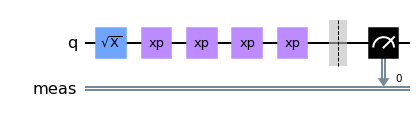

In [8]:
amp_cal.circuits(backend)[5].draw(output="mpl")

In [9]:
data_over = amp_cal.run(backend).block_for_results()

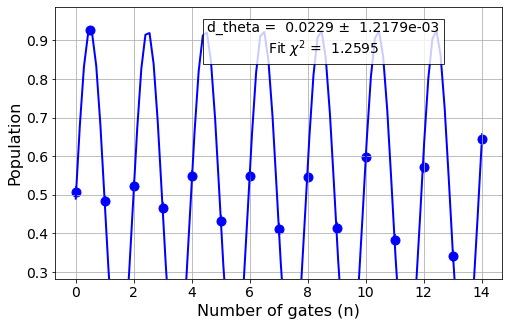

In [10]:
data_over.figure(0)

In [11]:
print(data_over.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: 0.022906292149891774 ± 0.0012178692224448
- χ²: 1.2595003872724588
- quality: good
- device_components: ['Q0']
- verified: False


In [12]:
dtheta = data_over.analysis_results("d_theta").value.value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.023 rad.
Thus, scale the 0.8146+0.0000j pulse amplitude by 0.993 to obtain 0.80874+0.00000j.
Amplitude reported by the backend 0.8066+0.0000j.


### Detecting an under-rotated pulse

In [13]:
pulse_amp = ideal_amp*0.99
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_under:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [14]:
amp_cal = FineXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=xp_under)

In [15]:
data_under = amp_cal.run(backend).block_for_results()

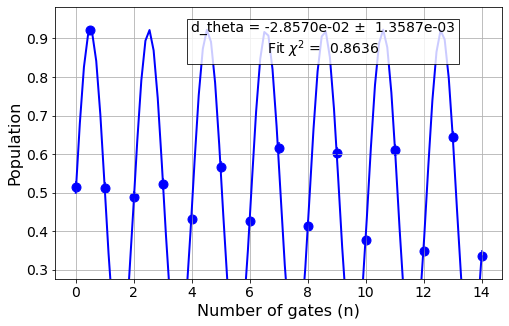

In [16]:
data_under.figure(0)

In [17]:
print(data_under.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.02857007076114283 ± 0.0013586515191557427
- χ²: 0.8636302781127537
- quality: good
- device_components: ['Q0']
- verified: False


In [18]:
dtheta = data_under.analysis_results("d_theta").value.value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.029 rad.
Thus, scale the 0.7985+0.0000j pulse amplitude by 1.009 to obtain 0.80584+0.00000j.
Amplitude reported by the backend 0.8066+0.0000j.


### Analyzing a $\frac{\pi}{2}$ pulse

We now consider the $\frac{\pi}{2}$ rotation. Note that in this case we do not need to add a $\frac{\pi}{2}$ rotation to the circuits.

In [19]:
pulse_amp = ideal_amp / 2
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [20]:
amp_cal = FineSXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=x90p)

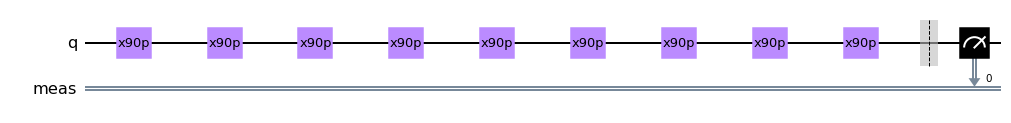

In [21]:
amp_cal.circuits(backend)[5].draw(output="mpl")

In [22]:
data_x90p = amp_cal.run(backend).block_for_results()

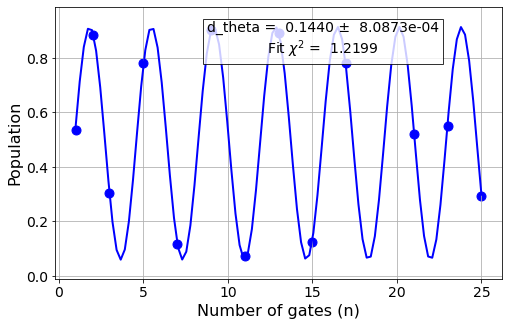

In [23]:
data_x90p.figure(0)

In [24]:
print(data_x90p.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: 0.1439910364991914 ± 0.0008087345633040481
- χ²: 1.2199458112094574
- quality: good
- device_components: ['Q0']
- verified: False


In [25]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

dtheta = data_x90p.analysis_results("d_theta").value.value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.144 rad.
Thus, scale the 0.4154+0.0000j pulse amplitude by 0.916 to obtain 0.38050+0.00000j.
Amplitude reported by the backend 0.3710-0.0773j.


Let's rerun this calibration using the updated value of the amplitude of the $\frac{\pi}{2}$ pulse.

In [26]:
pulse_amp = ideal_amp / 2 * scale
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [27]:
amp_cal.set_experiment_options(schedule=x90p)

In [28]:
data_x90p = amp_cal.run(backend).block_for_results()

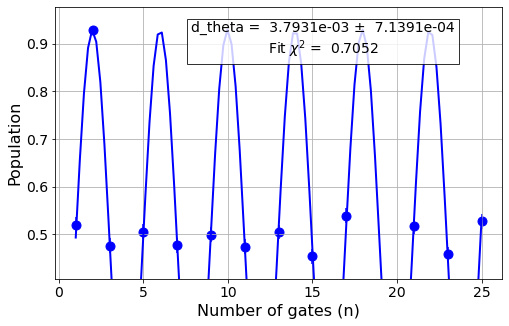

In [29]:
data_x90p.figure(0)

In [30]:
print(data_x90p.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: 0.0037930686077007622 ± 0.000713913947195575
- χ²: 0.705199260759621
- quality: good
- device_components: ['Q0']
- verified: False


In [31]:
dtheta = data_x90p.analysis_results("d_theta").value.value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.004 rad.
Thus, scale the 0.3805+0.0000j pulse amplitude by 0.998 to obtain 0.37959+0.00000j.
Amplitude reported by the backend 0.3710-0.0773j.


## Fine DRAG Calibrations

In [5]:
from qiskit_experiments.library import FineDrag

In [6]:
ideal_beta = x_pulse.beta
print(f"The reported beta of the X pulse is {ideal_beta:.4f}.")

The reported beta of the X pulse is -0.6864.


In [7]:
pulse_beta = ideal_beta*2.0
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=x_pulse.amp, sigma=x_pulse.sigma, beta=pulse_beta
        ), 
        pulse.drive_channel(qubit)
    )

In [8]:
drag_cal = FineDrag(qubit)
drag_cal.set_experiment_options(schedule=xp_over)

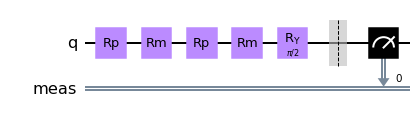

In [9]:
drag_cal.circuits()[2].draw("mpl")

In [10]:
drag_cal.circuits()[4].calibrations

{'Rp': {((0,),
   ()): ScheduleBlock(Play(Drag(duration=320, amp=(0.8079650037754826+0j), sigma=80, beta=-1.3728883331705073), DriveChannel(0)), name="xp", transform=AlignLeft())},
 'Rm': {((0,),
   ()): ScheduleBlock(ShiftPhase(3.141592653589793, DriveChannel(0)), Call(ScheduleBlock(Play(Drag(duration=320, amp=(0.8079650037754826+0j), sigma=80, beta=-1.3728883331705073), DriveChannel(0)), name="xp", transform=AlignLeft()), name='call_xp'), ShiftPhase(-3.141592653589793, DriveChannel(0)), name="rm", transform=AlignLeft())}}

In [ ]:
data_drag_x = drag_cal.run(backend)
data_drag_x.block_for_results()

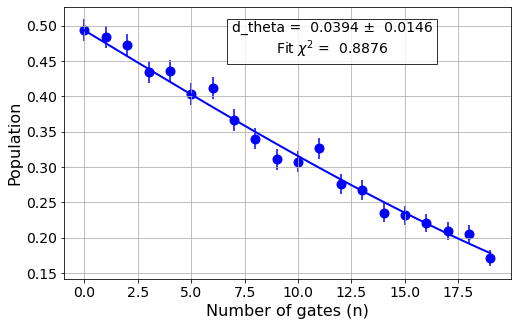

In [14]:
data_drag_x.figure(0)

In [20]:
print(data_drag_x.analysis_results(0))

DbAnalysisResultV1
- name: @Parameters_FineAmplitudeAnalysis
- value: [0.92633217 0.03939894 0.49316406] ± [0.28141044 0.01463978 0.00852977]
- χ²: 0.8875853449324372
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False


In [ ]:
dtheta = data_drag_x.analysis_results("d_theta").value.value

In [27]:
dtheta = data_drag_x.analysis_results("d_theta").value.value

ddelta = -0.25 * np.sqrt(np.pi) * dtheta * x_pulse.sigma / ((target_angle**2) / 4)

print((ddelta+1)*x_pulse.beta)

-0.2978869667368932


In [46]:
pulse_beta = (ddelta+1)*x_pulse.beta
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=x_pulse.amp, sigma=x_pulse.sigma, beta=pulse_beta
        ), 
        pulse.drive_channel(qubit)
    )

In [47]:
drag_cal = FineDrag(qubit)
drag_cal.set_experiment_options(rp_schedule=xp_over)

In [48]:
data_drag_x = drag_cal.run(backend)
data_drag_x.block_for_results()

ExperimentData(FineDrag, 414a305b-123a-4ba2-b60f-f2a8181866c4, backend=ibmq_armonk, job_ids=['613217e361ab23507bbead34'])

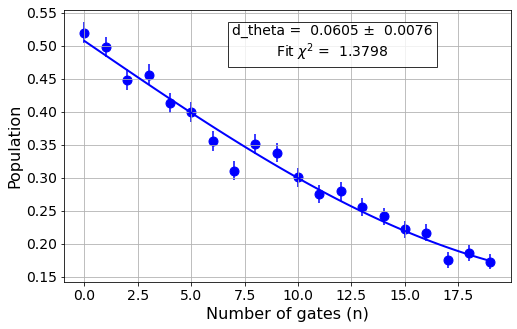

In [49]:
data_drag_x.figure(0)

In [50]:
print(data_drag_x.analysis_results(0))

DbAnalysisResultV1
- name: @Parameters_FineAmplitudeAnalysis
- value: [0.72971645 0.06052838 0.50691642] ± [0.05423192 0.00758006 0.00857818]
- χ²: 1.3798285198899418
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False


In [51]:
dtheta = data_drag_x.analysis_results("d_theta").value.value

ddelta = -0.25 * np.sqrt(np.pi) * dtheta * x_pulse.sigma / ((target_angle**2) / 4)

print((ddelta+1)*x_pulse.beta)

-0.08950581906410225


In [32]:
import qiskit.tools.jupyter
%qiskit_copyright